In [2]:
import numpy as np
#from hankel_dmd import *
from numerical_solvers_and_models import *
from scipy.interpolate import Rbf
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

ModuleNotFoundError: No module named 'numerical_solvers_and_models'

Below is all of the necessary RBF code.  I'll be damned, it works.  Go figure.  

In [31]:
def table_of_rbf_funs(shandle):
    dict_of_funs = {'multiquadric': lambda r,ep: np.sqrt((r/ep)**2. + 1.), 
                    'inverse': lambda r,ep: 1.0/np.sqrt((r/ep)**2. + 1.),
                    'gaussian': lambda r,ep: np.exp(-(r/ep)**2.),
                    'linear': lambda r,ep: r,
                    'cubic': lambda r,ep: r**3.,
                    'quintic': lambda r,ep: r**5.,
                    'thin_plate': lambda r,ep: r**2. * np.ma.log(r)}
    return dict_of_funs[shandle]
    
def table_of_rbf_jac_funs(shandle):
    dict_of_funs = {'multiquadric': lambda r,ep: (r/ep**2.)/np.sqrt((r/ep)**2. + 1.), 
                    'inverse': lambda r,ep: -(r/ep**2.)/((r/ep)**2. + 1.)**(1.5),
                    'gaussian': lambda r,ep: -2.*r/ep**2. * np.exp(-(r/ep)**2.),
                    'linear': lambda r,ep: 1.,
                    'cubic': lambda r,ep: 3.*r**2.,
                    'quintic': lambda r,ep: 5.*r**4.,
                    'thin_plate': lambda r,ep: r* (2.*np.ma.log(r)+1.)}
    return dict_of_funs[shandle]

def distance_matrix(ipts):
    nfvls = np.shape(ipts)[0]
    xcoords = np.zeros((nfvls, 1), dtype=np.float64)
    ycoords = np.zeros((nfvls, 1), dtype=np.float64)
    zcoords = np.zeros((nfvls, 1), dtype=np.float64)
    xcoords[:,0] = ipts[:,0]
    ycoords[:,0] = ipts[:,1]
    zcoords[:,0] = ipts[:,2]
    difx = np.tile(xcoords.T,(nfvls,1)) - np.tile(xcoords,(1,nfvls))
    dify = np.tile(ycoords.T,(nfvls,1)) - np.tile(ycoords,(1,nfvls))
    difz = np.tile(zcoords.T,(nfvls,1)) - np.tile(zcoords,(1,nfvls))
    dist = np.sqrt(difx**2. + dify**2. + difz**2.)
    return dist

def shape_parameter_tuner(ipts, shandle):
    emin = 900.
    emax = 1000.
    epvals = np.linspace(emin, emax, 101)
    myrbf = table_of_rbf_funs(shandle)    
    dist = distance_matrix(ipts)
    
    testfunc = lambda x,y,z: np.sinc(x)*np.sinc(y)*np.sinc(z)
    rhs = testfunc(ipts[:,0], ipts[:,1], ipts[:,2])
    max_error = np.zeros(epvals.size)
    for i in range(epvals.size):
        phimat = myrbf(dist,epvals[i])
        invphimat = np.linalg.pinv(phimat)
        error_func = (np.matmul(invphimat, rhs))/np.diag(invphimat)
        max_error[i] = np.linalg.norm(error_func, np.inf)
    opt_ind = np.argmin(max_error)
    opt_eps = epvals[opt_ind]    
    plt.plot(epvals,np.ma.log10(max_error))
    return opt_eps

def my_rbf_interpolator(ipts, fipts, qpt, shandle, epsilon):
    nfvls = np.shape(ipts)[0]
    myrbf = table_of_rbf_funs(shandle) 
    jacmyrbf = table_of_rbf_jac_funs(shandle)    
    dist = distance_matrix(ipts)    
    phimat = myrbf(dist,epsilon)
    cvals = np.linalg.solve(phimat,fipts)
    
    jacmat = np.zeros((3,3), dtype=np.float64)
    dqdxj = np.tile(np.reshape(qpt, (1,3)),(nfvls,1)) - ipts
    qdists = np.linalg.norm(dqdxj, axis=1)
    jacdists = jacmyrbf(qdists,epsilon)/qdists
    
    vecxdir = np.zeros((1, nfvls), dtype=np.float64)
    vecydir = np.zeros((1, nfvls), dtype=np.float64)
    veczdir = np.zeros((1, nfvls), dtype=np.float64)
    vecxdir[0,:] = cvals[:,0]*jacdists
    vecydir[0,:] = cvals[:,1]*jacdists
    veczdir[0,:] = cvals[:,2]*jacdists
    jacmat[0,:] = vecxdir @ dqdxj
    jacmat[1,:] = vecydir @ dqdxj
    jacmat[2,:] = veczdir @ dqdxj
    return jacmat, np.linalg.cond(phimat)

def condition_number_compute(ipts, shandle, epsilon):
    myrbf = table_of_rbf_funs(shandle) 
    jacmyrbf = table_of_rbf_jac_funs(shandle)
    dist = distance_matrix(ipts)    
    phimat = myrbf(dist,epsilon)
    return np.linalg.cond(phimat)

## The Lorenz Equation

Just to get our feet wet and to build some more direct familiarity with Takens Embedding Theorem, we turn to one of the classics of dynamical systems, the Lorenz-63 equations, given by the system

\begin{align}
\dot{y}_{1} = & \sigma(y_{2}-y_{1})\\
\dot{y}_{2} = & ry_{1} - y_{2} - y_{1}y_{3}\\
\dot{y}_{3} = & -by_{3} + y_{1}y_{2}
\end{align}

Following the approach laid out in *Broomhead et al, Physica D, 217-236, 1986*, we use the parameter values

$$
\sigma = 16, \quad b = 4, \quad r = 40
$$

starting from an initial condition of ${\bf x} = (0,1,0)$.  A general solution for generic initial condition ${\bf x}$ can be described via the flow map ${\bf y}(t) = \varphi(t;{\bf x})$ which in coordinates is given by
$$
\varphi(t;{\bf x}) = (y_{1}(t;{\bf x}), y_{2}(t;{\bf x}), y_{3}(t;{\bf x})), \quad y_{j}(0;{\bf x}) = x_{j}, ~ j=1,2,3.
$$

We numerically solve this on the time interval $0\leq t \leq 90$ using a fourth order Runge-Kutta scheme with a time step of $\delta t=.01$.  As we expect, we get the now famous *Lorenz Butterfly* when we parametrically plot the solution paths against one another.  

In [32]:
sigma = 16.
bval = 4.
rval = 40.
dt = .01
t0 = 0.
tf = 120.
tvals = np.linspace(t0,tf,int((tf-t0)/dt)+1)
x0 = np.array([0., 1., 0.])
fhandle = lambda x: lorentz(x,sigma,rval,bval)
rawdata = timestepper(x0, t0, tf, dt, fhandle)

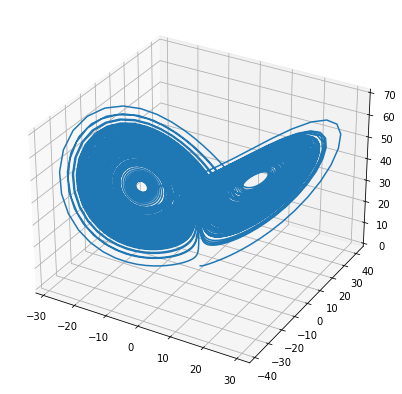

In [33]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot3D(rawdata[0,:], rawdata[1,:], rawdata[2,:])

## Lyupanov Exponents using the Model Equations

For a given solution, we can compute the affiliated Jacobian of the Lorenz equations, thereby generating the affiliated time-dependent linear system 

$$
\frac{d{\bf U}}{dt} = J(t){\bf U}, ~ {\bf U}(0) = {\bf I},
$$

where

$$
J(t) = \begin{pmatrix}
-\sigma & \sigma & 0 \\ r-y_{3}(t) & -1 & -y_{1}(t) \\ y_{2}(t) & y_{1}(t) & -b
\end{pmatrix}
$$

Using a discretized approximation to the solution of the original Lorenz system defined at discrete times $\left\{t_{j}\right\}_{j=0}^{N_{T}}$ where $t_{0}=0$ and $t_{j} = j\delta t$, to generate an approximation to the Lyupanov exponents, we solve for $t_{j}\leq t \leq t_{j+1}$: 
$$
\frac{d}{dt}{\bf U}_{j} = J(t){\bf U}_{j}, ~ {\bf U}_{j}(t_{j}) = {\bf Q}_{j}
$$
where ${\bf Q}_{0}={\bf I}$ and we perform a QR-decomposition such that 
$$
{\bf U}_{j}(t_{j+1}) = {\bf Q}_{j+1}{\bf R}_{j+1}
$$
Then the $m^{th}$ Lyupanov exponent $\lambda_{m}$ is found from the formula 
$$
\lambda_{m} = \lim_{j\rightarrow \infty}\frac{1}{t_{j}}\sum_{k=1}^{j}\log  \left|({\bf R}_{k})_{mm} \right|
$$
For further details on the theory here, see **Dieci et al, On the Computation of Lyapunov Exponents for Continuous Dynamical Systems, SIAM J. Num. Analysis, 34, 402-423, 1997**.

In [34]:
lyu_vals = lorenz_lyupanov_solver(rawdata, sigma, rval, bval, dt)

In [35]:
print(lyu_vals)

[  1.26170055   0.02791289 -22.28695891]


For the values used in Deici, we get comparable approximations to those listed in their tables for the Lorenz63 equations.  Thus we have a believable baseline now.  

Now to get estimates of Lyupanov exponents from just data alone, we need estimates of Jacobians of maps we otherwise do not have access to.  In Abarbanel et al, this is dealt with via least-squares fitting to Taylor series expansions.  Aside from being algorithmically unweildy, I also wonder how accurate that really is in the long run.  

Thus, I propose instead to use Radial Basis Functions (RBFs) to do scattered interpolation to generate analytic approximations to the map at each time step using nearest-neighbors to a given point ${\bf y}(t_{j})$.  This should produce a sequence of approximate Jacobians, say $\tilde{{\bf J}}_{j}$.  From time step to time step, we have the analytic formula for the matrices ${\bf U}_{j}$

$$
{\bf U}_{j}(t_{j+1}) = {\bf Q}_{j} + \int_{t_{j}}^{t_{j+1}}{\bf J}(t){\bf U}_{j}(t)dt
$$

To get a stable approximation scheme, we can use a Trapezoid approximation to the integral so that

$$
\left({\bf I} - \frac{\delta t}{2} {\bf J}_{j+1} \right){\bf U}_{j}(t_{j+1}) = \left({\bf I} + \frac{\delta t}{2} {\bf J}_{j} \right){\bf Q}_{j}.
$$

In [36]:
# keep around for testing purposes
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[0, 0] = -sigma
pjac_mat_exact[0, 1] = sigma
pjac_mat_exact[1, 1] = -1.
pjac_mat_exact[2, 2] = -bval

So to test, we cut off the first 400 timesteps to avoid transients, and then we generate a list of the 100 nearest neighbors to every point on the trajectory.  We then compare the numerically approximated Jacobian to the actual one.  Turns out, not half bad using Gaussian RBFs with a shape parameter set to $\epsilon = 10$.  Could do better possibly, but we'll have to explore that issue.  

In [37]:
transient_skp = 400
reddata = rawdata[:,transient_skp:]
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

In [38]:
def jacobian_maker(reddata, indices, dt, epval, jj):
    dstp = 1e-6

    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    fwdvls = reddata[:,np.mod(nnindices+np.ones(np.size(nnindices), dtype=int),NTT)]
    bwdvls = reddata[:,np.mod(nnindices-np.ones(np.size(nnindices), dtype=int),NTT)]
    fipts = (fwdvls - bwdvls)/(2.*dt)
    jacmat, cval = my_rbf_interpolator(ipts.T, fipts.T, yloc+dstp*np.ones(3,dtype=np.float64), shandle, epval)
    return jacmat, cval
    

993.0


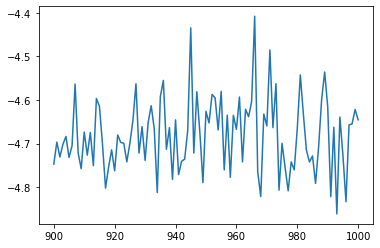

In [39]:
# tune for optimal epsilon using 'drop-one' algorithm
epval = shandle='gaussian'
current_ind = 10
yloc = reddata[:,current_ind]
nnindices = indices[current_ind]
ipts = reddata[:,nnindices]
epval = shape_parameter_tuner(ipts.T, shandle)
print(epval)

In [40]:
NTT = np.shape(reddata)[1]
for jj in range(10,11):
    
    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    
    pjac_mat_exact[1, 0] = rval-yloc[2]
    pjac_mat_exact[1, 2] = -yloc[0]
    pjac_mat_exact[2, 0] = yloc[1]
    pjac_mat_exact[2, 1] = yloc[0]
    
    jacmat, cval = jacobian_maker(reddata, indices, dt, epval, jj)
    print(jacmat)
    print(pjac_mat_exact)
    print("Condition number is: %1.2e" % cval)

[[-16.13994226  16.05189031  -0.11303454]
 [ -2.47675424  -1.10420757  13.13038285]
 [-10.861506   -12.82763789  -4.07170261]]
[[-16.          16.           0.        ]
 [ -2.80659735  -1.          13.05563049]
 [-10.58407758 -13.05563049  -4.        ]]
Condition number is: 1.01e+19


In [41]:
epvals = np.linspace(.1,20,1001)
ptindx = 10
dstp = 1e-6
yloc = reddata[:,ptindx]
nnindices = indices[ptindx]
ipts = reddata[:,nnindices]
fwdvls = reddata[:,np.mod(nnindices+np.ones(np.size(nnindices), dtype=int),NTT)]
bwdvls = reddata[:,np.mod(nnindices-np.ones(np.size(nnindices), dtype=int),NTT)]
fipts = (fwdvls - bwdvls)/(2.*dt)
condnumbers = [condition_number_compute(ipts.T, shandle, epval) for epval in epvals]

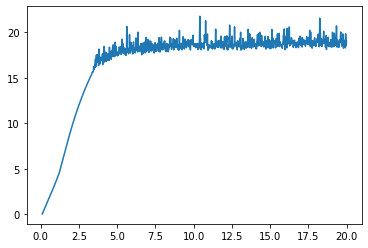

In [42]:
plt.plot(epvals, np.ma.log10(condnumbers))

Having established that the numerically approximated Jacobians are reasonably accurate, we now go ahead and compute the affiliated Lyupanov exponents.  

In [43]:
NTT = np.shape(reddata)[1]
qprior = np.eye(3,dtype=np.float64)
imat = np.eye(3,dtype=np.float64)
rvals = np.ones((3,NTT),dtype=np.float64)

for jj in range(NTT-1):
    
    jacmatn, cvaln = jacobian_maker(reddata, indices, dt, epval, jj)
    jacmatp, cvalp = jacobian_maker(reddata, indices, dt, epval, jj+1)
    
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat-dt/2*jacmatp),(imat+dt/2*jacmatn)@qprior))
    rvals[:,jj] = np.diag(rnext)
    
lvals = np.sum(np.log(np.abs(rvals)), 1)/tf

In [44]:
print(lvals)
print(lyu_vals)

[  0.97759414   0.45662124 -22.03810836]
[  1.26170055   0.02791289 -22.28695891]
